In [44]:
! git clone https://github.com/YousefGh/kmeans-feature-importance.git
! mv "./kmeans-feature-importance/kmeans_interp/" "."
! pip install -r "kmeans-feature-importance/requirements.txt"

fatal: destination path 'kmeans-feature-importance' already exists and is not an empty directory.
mv: cannot stat './kmeans-feature-importance/kmeans_interp/': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import cond
from sklearn.covariance import LedoitWolf
from numpy.linalg import pinv
from sklearn import preprocessing
from numpy.linalg import eig
from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [46]:
#Configurar colab para tomar datos de drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [47]:
#Cargar datos
path = '/content/gdrive/MyDrive/proyecto-integrador-grupo1/proyecto-integrador-data/marketing_campaign_clean.csv'
df = pd.read_csv(path, index_col=0,sep=',') 
df.head()

,User_Age,Income,Child_Count,Day_Cnt,Recency,Marital_Status_Joined,Education_Graduate,Education_Postgraduate,MntWines,MntFruits,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Purchases_Z1,Purchases_Z2,Purchases_Z3
0,57,58138.0,0,663.0,58,0,1,0,635,88,...,0,0,0,0,0,1,1617,-1.356723,1.065805,0.125977
1,60,46344.0,2,113.0,38,0,1,0,11,1,...,0,0,0,0,0,0,27,1.382012,-0.826501,0.548390
2,49,71613.0,0,312.0,26,1,1,0,426,49,...,0,0,0,0,0,0,776,-1.455412,0.076022,-1.369982
3,30,26646.0,1,139.0,26,1,1,0,11,4,...,0,0,0,0,0,0,53,1.258620,-0.358916,0.005120
4,33,58293.0,1,161.0,94,1,0,1,173,43,...,0,0,0,0,0,0,422,-0.269030,1.095667,0.770477


In [48]:
df.columns

Index(['User_Age', 'Income', 'Child_Count', 'Day_Cnt', 'Recency',
       'Marital_Status_Joined', 'Education_Graduate', 'Education_Postgraduate',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Spent', 'Purchases_Z1', 'Purchases_Z2', 'Purchases_Z3'],
      dtype='object')

In [49]:
#Eliminar algunas variables redundantes y las cuantitativas que explicará la regresión
to_drop = ['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','Spent']
to_scale = ['User_Age', 'Income', 'Child_Count', 'Day_Cnt', 'Recency',
       'Purchases_Z1', 'Purchases_Z2', 'Purchases_Z3']
data = df.drop(to_drop, axis=1)
X = data[to_scale]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)
X.columns = ['User_Age', 'Income', 'Child_Count', 'Day_Cnt', 'Recency',
       'Purchases_Z1', 'Purchases_Z2', 'Purchases_Z3']

In [50]:
X[['Marital_Status_Joined', 'Education_Graduate', 'Education_Postgraduate',
   'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']] = data[['Marital_Status_Joined', 'Education_Graduate', 'Education_Postgraduate',
   'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']]

In [51]:
Y = data
data = X
data

,User_Age,Income,Child_Count,Day_Cnt,Recency,Purchases_Z1,Purchases_Z2,Purchases_Z3,Marital_Status_Joined,Education_Graduate,Education_Postgraduate,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1.007629,0.500913,-1.257809,1.534232,0.320574,-1.119809,0.963413,0.248096,0,1,0,0,0,0,0,0,0,1
1,1.263009,-0.111161,1.398639,-1.176232,-0.372909,0.826723,-0.774694,0.939452,0,1,0,0,0,0,0,0,0,0
2,0.326614,1.200225,-1.257809,-0.195537,-0.788999,-1.189952,0.054285,-2.200314,1,1,0,0,0,0,0,0,0,0
3,-1.290795,-1.133429,0.070415,-1.048101,-0.788999,0.739024,-0.345211,0.050292,1,1,0,0,0,0,0,0,0,0
4,-1.035415,0.508957,0.070415,-0.939682,1.568843,-0.346741,0.990842,1.302939,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,1.177883,-0.729929,0.070415,0.735877,1.118079,1.217925,-0.728462,-0.220321,1,1,0,0,0,0,0,0,0,0
1920,1.603517,0.805859,1.398639,-1.442350,0.251225,-0.138226,2.506890,0.792452,1,0,1,0,0,0,1,0,0,0
1921,-2.227190,0.440868,-1.257809,1.346964,1.464821,-0.774817,-0.430224,-0.494757,0,1,0,0,1,0,0,0,0,0
1922,-0.609781,1.077333,0.070415,-0.087118,-1.413134,-1.500276,-0.153270,-0.146124,1,0,1,0,0,0,0,0,0,0


Elbow Method to determine the number of clusters to be formed:


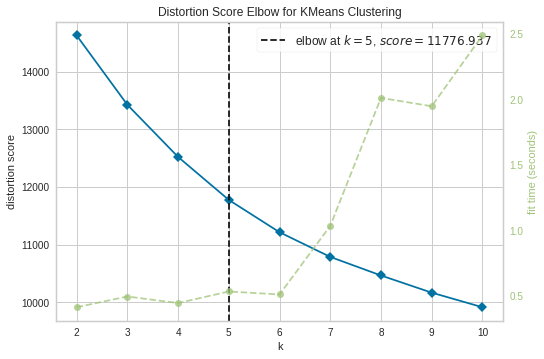

In [52]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data)
Elbow_M.show()

#By default, the scoring parameter metric is set to distortion, which computes 
#the sum of squared distances from each point to its assigned center. However, 
#two other metrics can also be used with the KElbowVisualizer – silhouette and 
#calinski_harabasz. The silhouette score calculates the mean Silhouette Coefficient 
#of all samples, while the calinski_harabasz score computes the ratio of dispersion 
#between and within clusters.
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

In [53]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp
kms = KMeansInterp(
	n_clusters=5,
	ordered_feature_names=data.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(data.values)

kms.feature_importances_

{0: [('Purchases_Z3', 1.360690342093038),
  ('Purchases_Z1', 0.8576564169563134),
  ('Purchases_Z2', 0.8208510872694814),
  ('Income', 0.665027347144215),
  ('Marital_Status_Joined', 0.6470588235294117),
  ('Education_Graduate', 0.4674922600619194),
  ('Education_Postgraduate', 0.46130030959752344),
  ('Response', 0.16718266253869968),
  ('AcceptedCmp4', 0.15789473684210537),
  ('Recency', 0.11108191739875327),
  ('AcceptedCmp3', 0.08668730650154806),
  ('Day_Cnt', 0.06720722640585443),
  ('AcceptedCmp5', 0.05263157894736841),
  ('AcceptedCmp1', 0.04953560371517031),
  ('Child_Count', 0.04574230518166418),
  ('AcceptedCmp2', 0.027863777089783277),
  ('User_Age', 0.011671561699557726),
  ('Complain', 0.009287925696594432)],
 1: [('Income', 1.2511269497792339),
  ('Purchases_Z1', 1.213931517852613),
  ('Purchases_Z2', 0.7786533694960809),
  ('Marital_Status_Joined', 0.6424870466321243),
  ('Education_Graduate', 0.49740932642487035),
  ('Education_Postgraduate', 0.4274611398963732),
  ('P

In [54]:
# Fit K-means for 5 centroids
kmeans = KMeans(n_clusters=5, 
                random_state=0).fit(data)
# Get volume assigned to each cluster
data['Kmeans_Clusters'] = kmeans.predict(data)

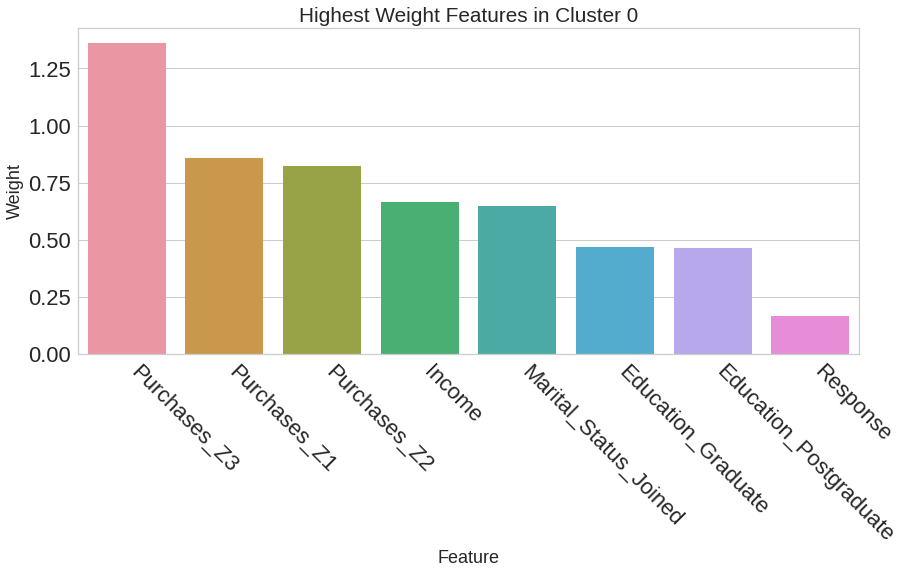

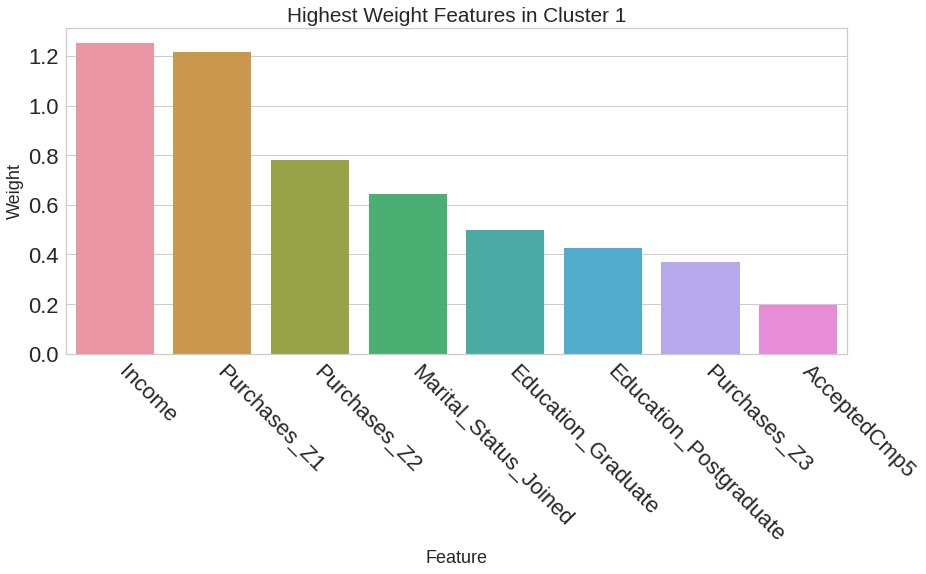

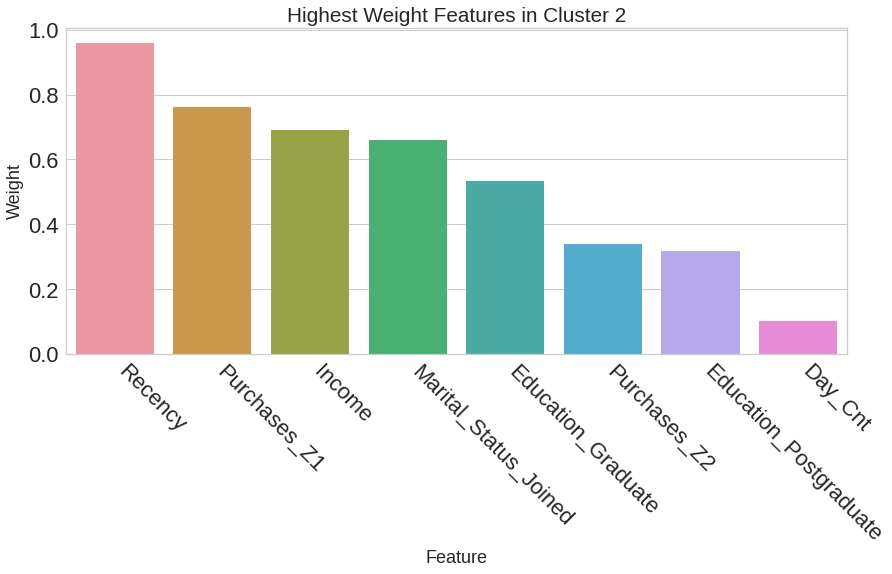

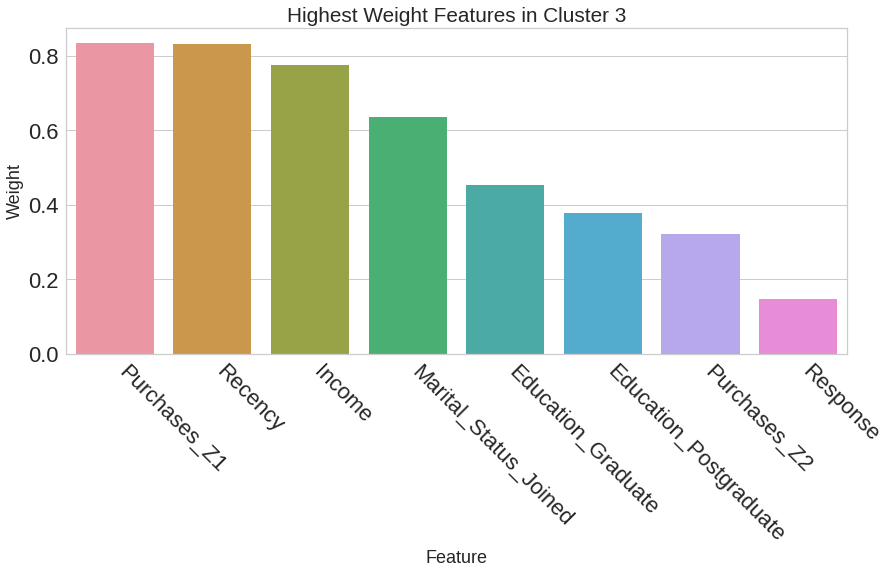

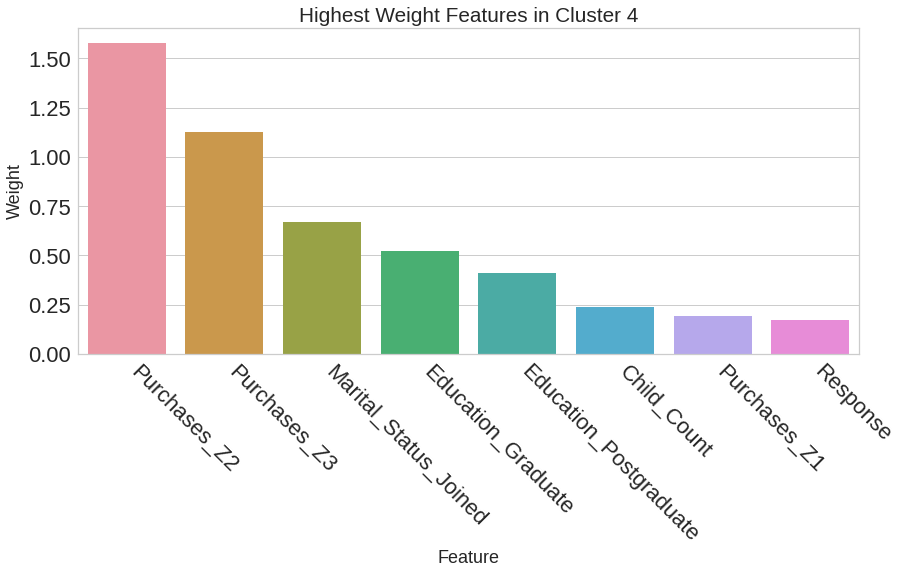

In [55]:
#https://colab.research.google.com/drive/1IpXgVINkBuyOJ1Hg06OHoJf-mXO_C6qc?usp=sharing#scrollTo=PAjct8X8_Hr_

for cluster_label, feature_weights in kms.feature_importances_.items():    
    df_feature_weight = pd.DataFrame(feature_weights[:8], columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left");
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Highest Weight Features in Cluster {cluster_label}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize=18)
    plt.ylabel('Weight', fontsize=18)
    
    plt.savefig(f'feature_weights_clusters_kmeans_{cluster_label}.png', bbox_inches='tight')

    # plt.show();
    
    print('\n\n')

In [56]:
#MeanShift 
#https://towardsdatascience.com/understanding-mean-shift-clustering-and-implementation-with-python-6d5809a2ac40
bandwidth = estimate_bandwidth(Y, quantile=0.3, n_samples=300)
ms = MeanShift(bandwidth=bandwidth)
ms.fit(Y)
#Meanshift labels
data['MS_Clusters'] = ms.labels_

In [57]:
#kmeans_centers = pd.DataFrame(kmeans.cluster_centers_)
#MS_centers = pd.DataFrame(ms.cluster_centers_)
Z = np.array(X)
#Z['Clusters'] = data['Kmeans_Clusters']
#kmeans_centers['clusters'] = data['Kmeans_Clusters']

In [58]:
# dist1 = np.linalg.norm(Z - kmeans.cluster_centers_[data['Kmeans_Clusters']],axis=1).reshape(-1,1)
# dist2 = np.linalg.norm(Z - ms.cluster_centers_[data['MS_Clusters']],axis=1).reshape(-1,1)

In [59]:
# dist2

In [60]:
data['Spent'] = df['MntFishProducts'] + df['MntFruits'] + df['MntGoldProds'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

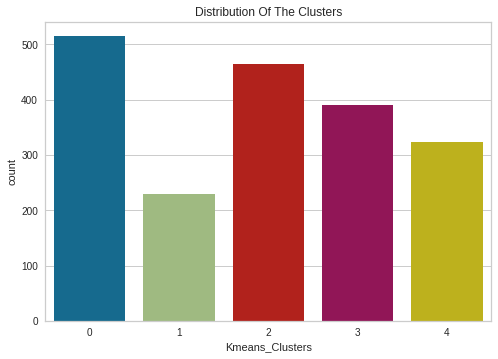

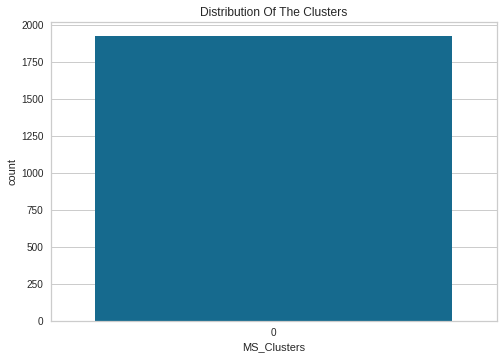

In [61]:
#Plotting countplot of clusters
#pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
#pl = sns.countplot(x=data["Kmeans_Clusters"], palette= pal)
#pl.set_title("Distribution Of The Clusters")
#plt.show()

plt.figure() 
pl = sns.countplot(x=data["Kmeans_Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.savefig('distribucion_clusters_kmeans.png', bbox_inches='tight')

plt.figure()
pl = sns.countplot(x=data["MS_Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.savefig('distribucion_clusters_meanshift.png', bbox_inches='tight')


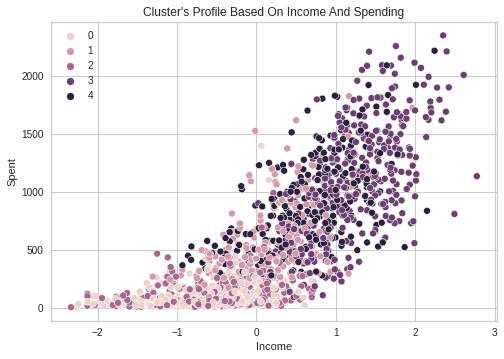

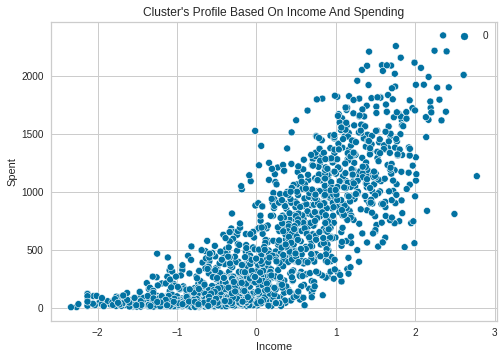

In [62]:
#Spent representa el gasto total de los clientes
plt.figure() 
pl = sns.scatterplot(data = data,x=data["Income"], y=data["Spent"],hue=data["Kmeans_Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.savefig('scatterplot_spent_income_kmeans.png', bbox_inches='tight')

plt.figure() 
pl = sns.scatterplot(data = data,x=data["Income"], y=data["Spent"],hue=data["MS_Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.savefig('scatterplot_spent_income_meanshift.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 77.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you

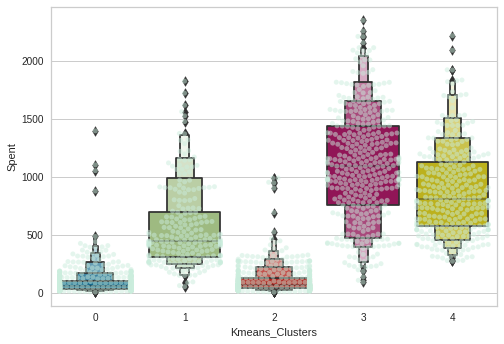

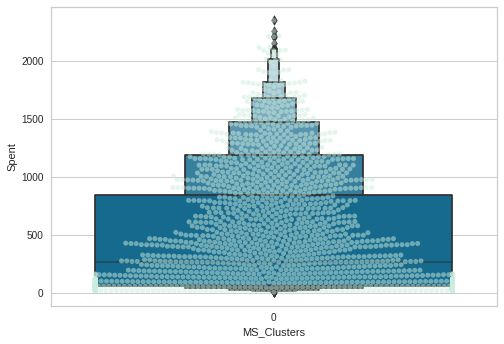

In [63]:
#Comparación de Spent en cada cluster
plt.figure()
pl=sns.swarmplot(x=data['Kmeans_Clusters'], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data['Kmeans_Clusters'], y=data["Spent"])
plt.savefig('boxplot_spent_kmeans.png', bbox_inches='tight')

plt.figure()
pl=sns.swarmplot(x=data['MS_Clusters'], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data['MS_Clusters'], y=data["Spent"])
plt.savefig('boxplot_spent_meanshift.png', bbox_inches='tight')

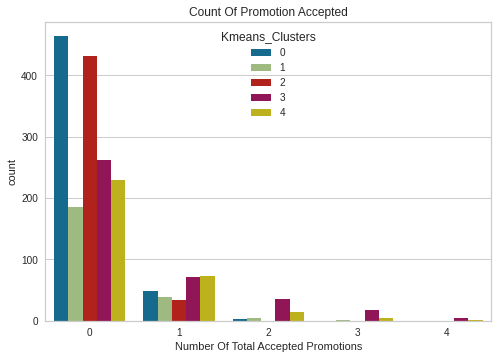

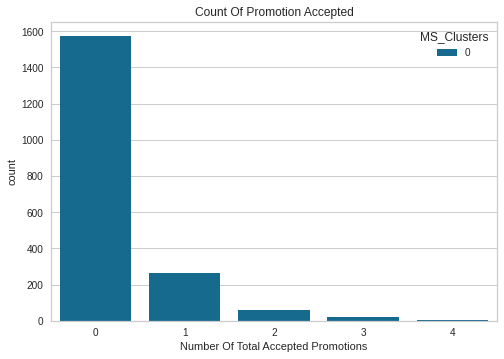

In [64]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.

plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data['Kmeans_Clusters'])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.savefig('countplot_total_promos_kmeans.png', bbox_inches='tight')

plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data['MS_Clusters'])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.savefig('countplot_total_promos_meanshift.png', bbox_inches='tight')

In [65]:
data.columns

Index(['User_Age', 'Income', 'Child_Count', 'Day_Cnt', 'Recency',
       'Purchases_Z1', 'Purchases_Z2', 'Purchases_Z3', 'Marital_Status_Joined',
       'Education_Graduate', 'Education_Postgraduate', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Kmeans_Clusters', 'MS_Clusters', 'Spent',
       'Total_Promos'],
      dtype='object')

**Profiling**

<Figure size 576x396 with 0 Axes>

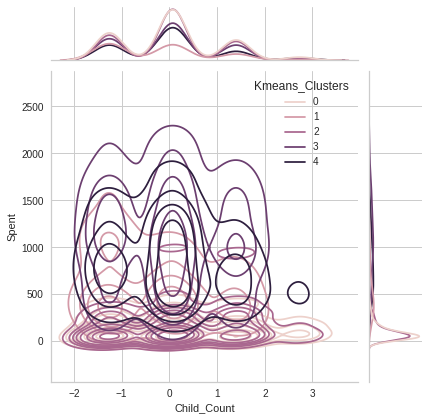

<Figure size 576x396 with 0 Axes>

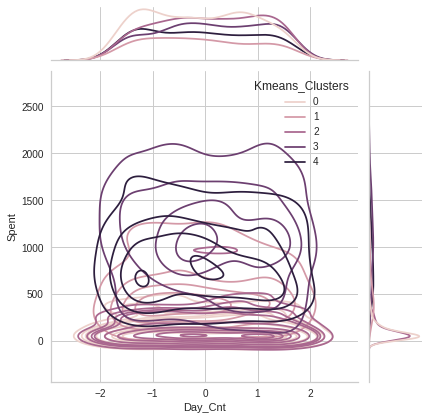

<Figure size 576x396 with 0 Axes>

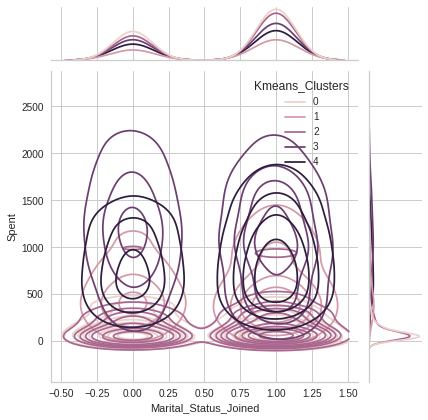

<Figure size 576x396 with 0 Axes>

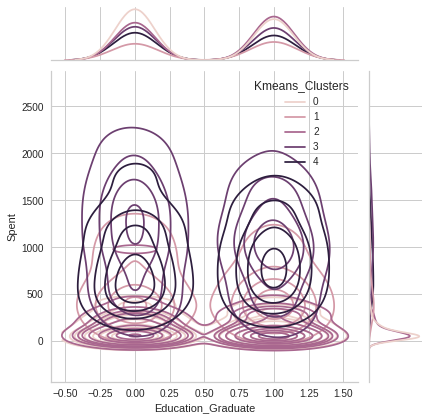

<Figure size 576x396 with 0 Axes>

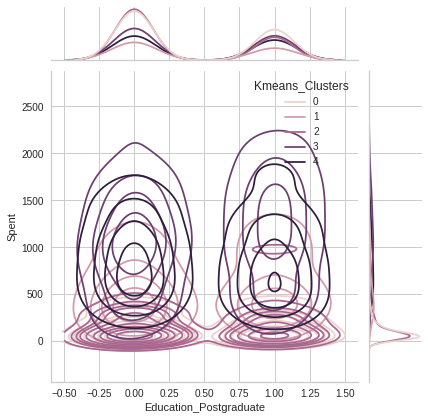

In [66]:
#https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering
Personal = [ "Child_Count","Day_Cnt","Marital_Status_Joined", "Education_Graduate","Education_Postgraduate"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data['Kmeans_Clusters'], kind="kde")
    plt.show()